In [10]:
import os
os.chdir(os.getenv("WORKINGDIR"))
from tqdm.notebook import tqdm
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from skipper_image_analysis.utils import (
    plot_ccd_image, correct_overscan, get_rowcol_ovserscan
)
from scipy.optimize import curve_fit

# Matplotlib settings
%config InlineBackend.figure_format = "retina"  # For high dpi figures in notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"


GANANCIA = {
    0: 210,
    1: 232,
    2: 207,
    3: 159
}
PRESCAN_PIX = 8

CARPETAS_POR_TEMP: dict[str, list[str]] = {
    # 126: ["skipper_data/TRAPS/09NOV2023/",],
    # 127: ["skipper_data/TRAPS/16NOV2023_127K/",],
    140: ["skipper_data/TRAPS/10NOV2023_140K/", "skipper_data/TRAPS/16NOV2023_140K/"],
    150: ["skipper_data/TRAPS/11NOV2023_150K/", "skipper_data/TRAPS/11NOV2023_150K_bis/", "skipper_data/TRAPS/16NOV2023_150K"],
    
}

In [2]:
def prepare_frame(
    skipper_image: fits.hdu.hdulist.HDUList,
    frame_idx: int,
    remove_row_median: bool = True,
) -> ArrayLike:
    global GANANCIA, PRESCAN_PIX
    skipper_image = correct_overscan(skipper_image)  # A.D.U.
    frame = skipper_image[frame_idx].data  # A.D.U.
    r_overscan, c_overscan = get_rowcol_ovserscan(skipper_image)  # A.D.U.
    frame = frame[1:-r_overscan, PRESCAN_PIX:-c_overscan]  # A.D.U.
    if remove_row_median:
        frame = frame - np.median(frame, axis=0)  # A.D.U.
    return frame/GANANCIA[frame_idx]  # e⁻


def filtro_dipolos(
    frame: ArrayLike,
    threshold: float = 5e5,  # e⁻
    corte_simetria: float = 20,  # %
) -> tuple[list, list, ArrayLike]:  # ACTUALIZAR EN CÓDIGO!
    """Busca dipolos en un frame de la CCD. Para ello, se calcula el producto entre \
cada pixel y su vecino inferior. Si el producto es menor que un umbral negativo, se \
considera que hay un dipolo. Luego, se revisa que el dipolo sea simétrico, es decir, \
que los valores de los pixeles sean similares en magnitud. Si el dipolo es simétrico, \
se agrega a la lista de dipolos encontrados. Finalmente, se devuelve una lista con \
las coordenadas de los dipolos, una máscara con los dipolos encontrados y una lista \
con los valores de los dipolos.

    Parameters:
    -----------

        `frame {ArrayLike}`: Frame de la CCD a analizar. Debe estar en unidades de \
electrones.

        `threshold {float, optional}`: Valor umbral en la clasificación de picos. \
Defaults to 5e5.

        `corte_simetria {float, optional}`: Defaults to 20.

    Returns:
    --------

        `{tuple[list, list, ArrayLike]}`:
    """
    prod_arr = frame[:-1] * frame[1:]
    val_trampas = []
    coordenadas_trampas = []
    mascara = np.zeros_like(frame)
    for j, col in enumerate(prod_arr.T):  # Recorro las columnas del frame
        for i, val in enumerate(col):  # Recorro los valores de cada columna
            if val < -threshold:
                # Reviso que no esté en el borde del frame
                if i == 0:
                    i_lleno = np.argmax(frame[i:i+2, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i:i+2, j])
                    i_vacio = i_vacio + i - 1
                elif i == len(col):
                    i_lleno = np.argmax(frame[i-1:i+1, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i-1:i+1, j])
                    i_vacio = i_vacio + i - 1
                else:
                    i_lleno = np.argmax(frame[i-1:i+2, j])
                    i_lleno = i_lleno + i - 1
                    i_vacio = np.argmin(frame[i-1:i+2, j])
                    i_vacio = i_vacio + i - 1
                if np.abs(i_lleno-i_vacio) == 1:  # Confirmo adyacencia
                    val_1  = frame[i_lleno, j]
                    val_2 = frame[i_vacio, j]
                    diferencia_relativa = np.abs(100*(np.abs(val_1)-np.abs(val_2))/np.max([np.abs(val_1), np.abs(val_2)]))
                    #print(diferencia_relativa)
                    if diferencia_relativa < corte_simetria: #filtro por simetría
                        coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
                        val_trampas.append(np.abs(val_1-val_2)/2)
                        mascara[i_lleno, j] = 1
                        mascara[i_vacio, j] = 1
    return coordenadas_trampas, val_trampas, mascara

# Imágenes LAMBDA

In [3]:
# Cargar Archivos desde sus Carpetas por Temperatura

temperatura = 150
data_dir = CARPETAS_POR_TEMP[temperatura][-1]
files_in_dir = os.listdir(data_dir)
valid_formats = ["fits",]  # "fz"]
files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
file_data = [f"{i}    " + "    ".join(filename.split("_")[2:]) for i, filename in enumerate(files_in_dir)]
print("Params in .fits Files in Directory:", *file_data, sep="\n")
i = -5
test_image = fits.open(f'{data_dir}/{files_in_dir[i]}')
print(f"\nLoaded {files_in_dir[i]}\n")


Params in .fits Files in Directory:
0    pocket    oled1row    2film    dTph1600    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img131.fits
1    pocket    oled1row    2film    dTph800    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img115.fits
2    pocket    oled1row    2film    dTph400    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img107.fits
3    pocket    oled1row    2film    dTph3200    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img155.fits
4    pocket    oled1row    2film    dTph1600    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img147.fits
5    pocket    oled1row    2film    dTph6400    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img157.fits
6    pocket    oled1row    2film    dTph400    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXPOSURE8.0    img105.fits
7    pocket    oled1row    2film    dTph800    NPUPMPS10000    NSAMP20    NROW879    NCOL336    EXP

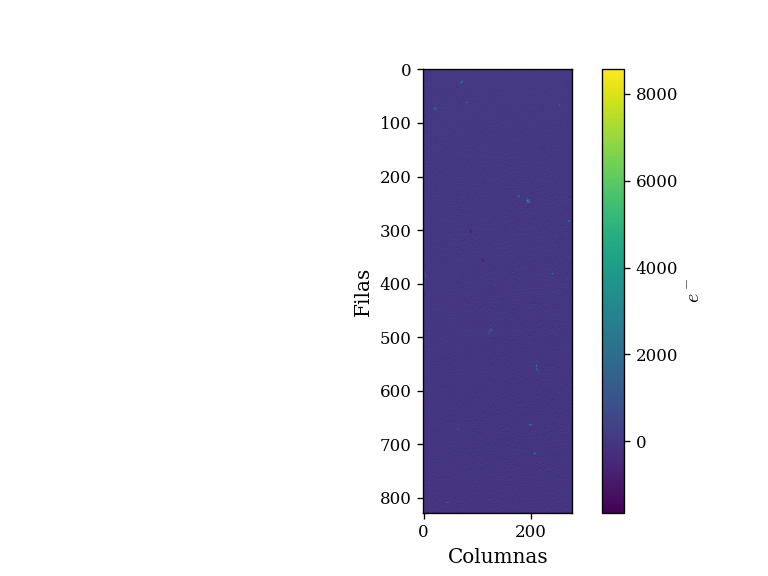

In [4]:
# Lectura del Frame y Corrección del Overscan
frame_idx = 0
test_frame = prepare_frame(test_image, frame_idx)  # e⁻

plt.close("all")
%matplotlib widget
fig, ax = plt.subplots(1, 1)
fig.set_label(f"Frame {frame_idx}")
mappable = ax.imshow(test_frame, cmap="viridis")
ax.set_xlabel("Columnas")
ax.set_ylabel("Filas")
# ax.set_xlim(100, 150)
# ax.set_ylim(100, 150)
plt.colorbar(mappable, label=r"$e^-$", ax=ax)
plt.show()

In [5]:
threshold = 5e5
corte_simetria = 20
coordenadas_trampas, val_trampas, mascara = filtro_dipolos(test_frame, threshold, corte_simetria)

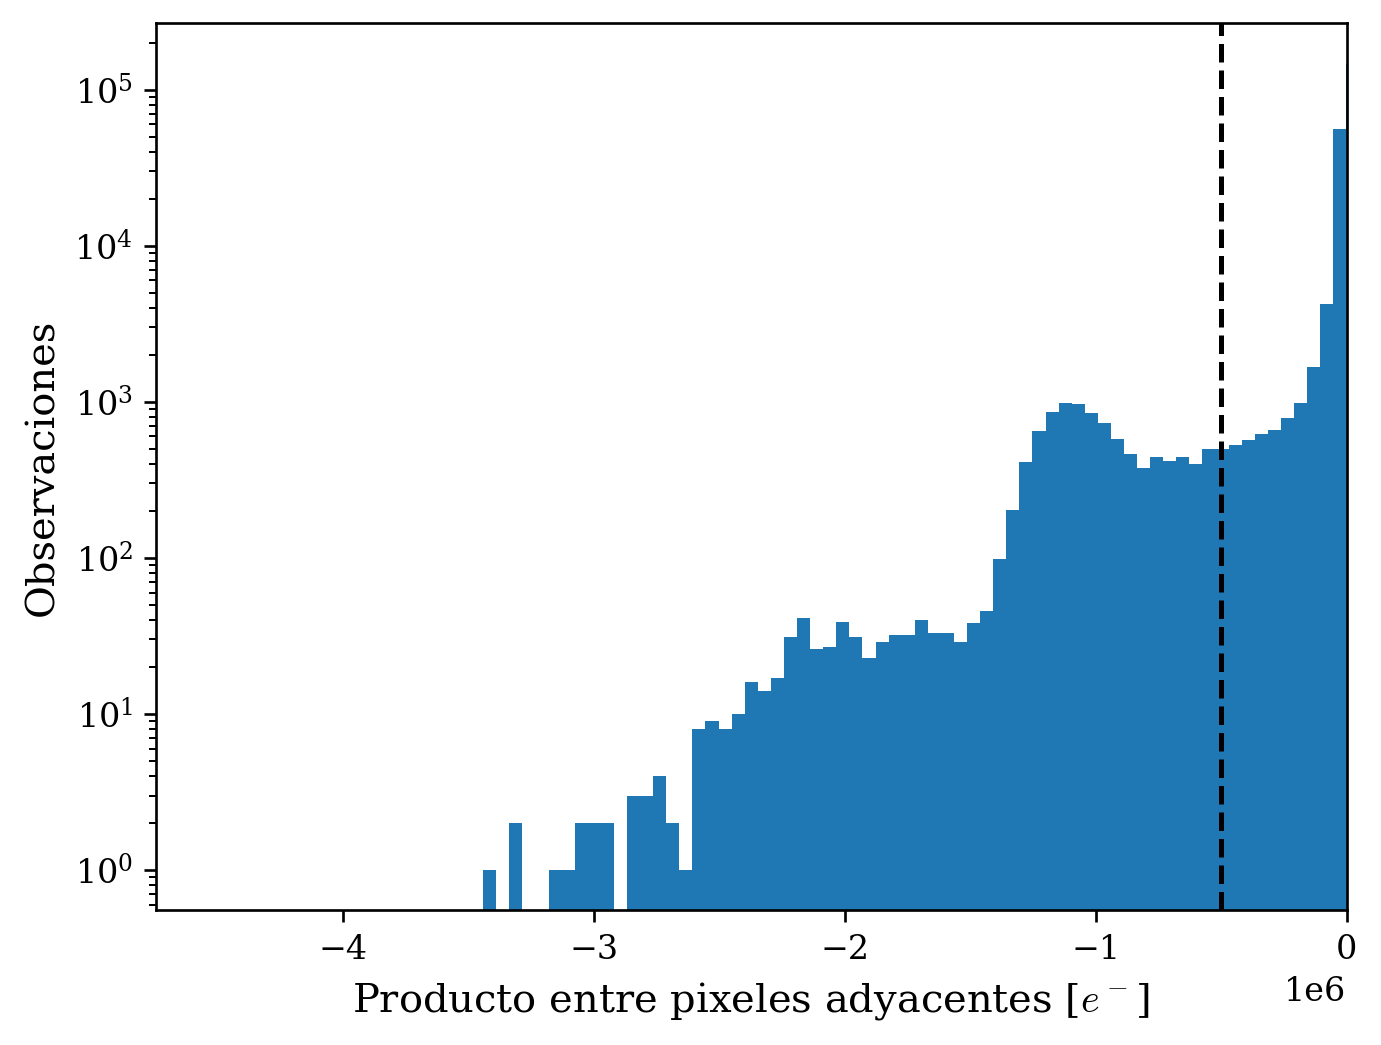

In [7]:
# EN PROGRESO...
plt.close("all")
%matplotlib inline
prod_arr = test_frame[:-1] * test_frame[1:]
plt.hist(prod_arr.flatten(), bins = 500)
plt.xlim(xmax = 0)
plt.yscale('log')
plt.axvline(x = -threshold, color='k', ls = '--')
plt.xlabel("Producto entre pixeles adyacentes [$e^-$]")
plt.ylabel("Observaciones")
#plt.ylim(ymax = 100)
plt.show()

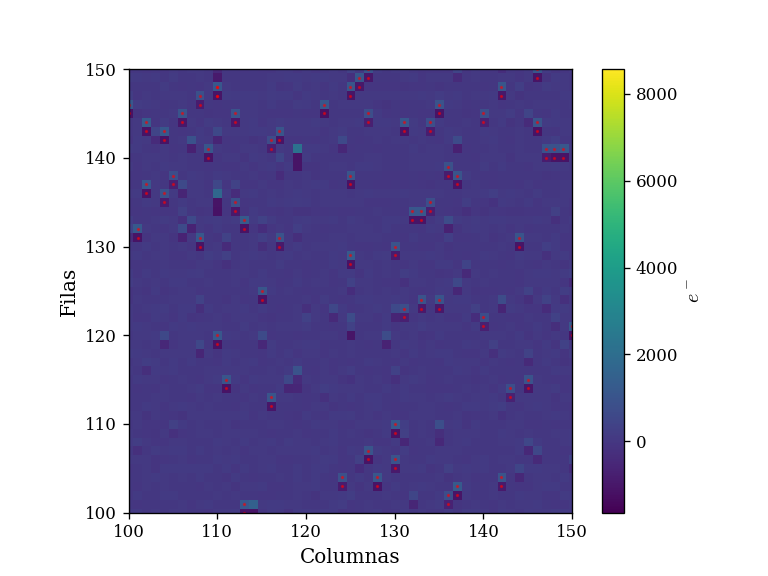

In [8]:
plt.close('all')
%matplotlib widget
fig, ax = plt.subplots(1, 1)
fig.set_label(f"Frame {frame_idx}")
mappable = ax.imshow(test_frame, cmap="viridis")
x_traps = []
y_traps = []
for coords in coordenadas_trampas:
    x_traps.append(coords[0][0])
    x_traps.append(coords[1][0])
    y_traps.append(coords[0][1])
    y_traps.append(coords[1][1])
plt.plot(y_traps, x_traps, '.r', ms=2, alpha=0.5)
ax.set_xlabel("Columnas")
ax.set_ylabel("Filas")
ax.set_xlim(100, 150)
ax.set_ylim(100, 150)
plt.colorbar(mappable, label=r"$e^-$", ax=ax)
plt.show()

In [13]:
# Cargar Archivos desde sus Carpetas por Temperatura
temperatura = 150
data_dir = CARPETAS_POR_TEMP[temperatura][0]
files_in_dir = os.listdir(data_dir)
valid_formats = ["fits",]  # "fz"]
files_in_dir = [f for f in files_in_dir if f.rsplit(".")[-1] in valid_formats]
file_data = [f"{i}    " + "    ".join(filename.split("_")[2:]) for i, filename in enumerate(files_in_dir)]
#print("Params in .fits Files in Directory:", *file_data, sep="\n")
frames_dict = dict()
coords_dict = dict()
vals_dict = dict()
prod_arr = dict()
mascara_dipolos = dict()
for file in tqdm(files_in_dir, desc="Procesando Archivos"):
    #print(file)
    dtph = int(file.rsplit("_")[5][4:])
    if dtph in coords_dict:
        continue
    #print(dtph)
    #i = -1
    test_image = fits.open(f'{data_dir}/{file}')
    frame_idx = 0
    frames_dict[dtph] = prepare_frame(test_image, frame_idx)  # e⁻
    threshold = 5e4
    corte_simetria = 20
    coords_dict[dtph], vals_dict[dtph], mascara_dipolos[dtph] = filtro_dipolos(
        frames_dict[dtph], threshold, corte_simetria
    )

    #print(f"\nLoaded {files_in_dir[i]}\n")


Procesando Archivos:   0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
#plt.close('all')
#mascara_trampas_fijas = np.ones_like(test_frame, dtype=int)
#dtph_vals = list(coords_dict.keys())
#for dtph in dtph_vals:
#    mascara_trampas_fijas = mascara_trampas_fijas*mascara_dipolos[dtph]

#%matplotlib widget
#fig, ax = plt.subplots(1, 1)
#fig.set_label(f"Frame {frame_idx}")
#mappable = ax.imshow(mascara_trampas_fijas, cmap="viridis")

#ax.set_xlabel("Columnas")
#ax.set_ylabel("Filas")
#ax.set_xlim(100, 150)
#ax.set_ylim(100, 150)
#plt.colorbar(mappable, label=r"$e^-$", ax=ax)
#plt.show()

In [13]:
trampas_consistentes = []
intensidad_por_trampa = []
dtph_vals = list(coords_dict.keys())
print(dtph_vals)
dtph_base = min(coords_dict.keys())
for candidatos in tqdm(
    coords_dict[dtph_base],
    desc="Recorriendo Candidatos",
    total=len(coords_dict[dtph_base]),
                       ):
    aparece = True
    intensidades_candidato = [] 
    for dtph in dtph_vals:
        coords = coords_dict[dtph]
        if candidatos in coords:
            indice = coords.index(candidatos)
            intensidades_candidato.append(vals_dict[dtph][indice])
        else:
            aparece = False
            break
    if aparece:
        trampas_consistentes.append(candidatos)
        intensidad_por_trampa.append(intensidades_candidato)


[100, 1600, 3200, 400, 50, 6400, 800]


Recorriendo Candidatos:   0%|          | 0/20801 [00:00<?, ?it/s]

In [27]:
# frame_revisado = np.zeros_like(test_frame, dtype=int)
coords_medidas = set()
trampas_halladas = []
intensidad_por_trampa = []
dtph_vals = list(coords_dict.keys())
dtph_vals = [dtph_vals[i] for i in np.argsort(dtph_vals)]
for dtph in tqdm(
    dtph_vals[::-1],
    desc="Recorriendo dTph",
    total=len(dtph_vals),
):
    coordenadas_trampas = coords_dict[dtph]
    for coords in coordenadas_trampas:
        if coords in coords_medidas:
            continue
        trampas_halladas.append(coords)
        intensidades_trampa = []
        for dtph_frames in dtph_vals:
            frame = frames_dict[dtph_frames]
            intensidades_trampa.append(np.abs(frame[coords[0]]-frame[coords[1]])/2)
        intensidad_por_trampa.append(intensidades_trampa)
        coords_medidas.add(coords)

Recorriendo dTph:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
plt.close('all')
%matplotlib widget
fig, ax = plt.subplots(1, 1)
fig.set_label(f"Frame {frame_idx}")
mappable = ax.imshow(test_frame, cmap="viridis")
x_traps = []
y_traps = []
for coords in trampas_halladas:
    x_traps.append(coords[0][0])
    x_traps.append(coords[1][0])
    y_traps.append(coords[0][1])
    y_traps.append(coords[1][1])
plt.plot(y_traps, x_traps, '.r', ms=2, alpha=0.5)
ax.set_xlabel("Columnas")
ax.set_ylabel("Filas")
ax.set_xlim(100, 150)
ax.set_ylim(100, 150)
plt.colorbar(mappable, label=r"$e^-$", ax=ax)
plt.show()

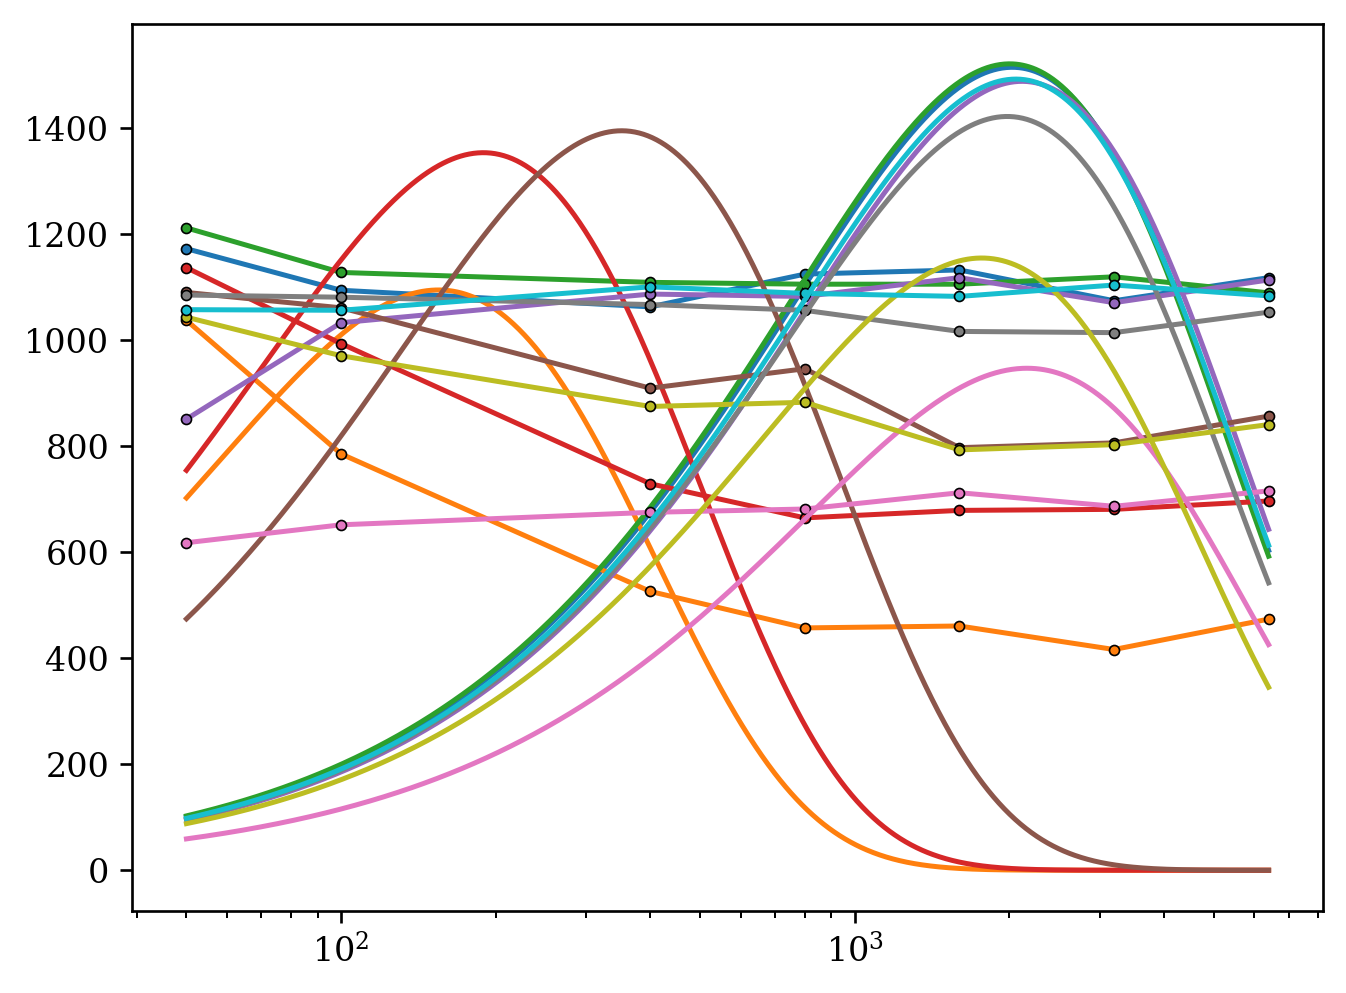

In [42]:
plt.close("all") 
def intensidad_func(tph, tau, Pc):
    return 40000*Pc*(np.exp(-tph/tau) - np.exp(-2*tph/tau))

%matplotlib inline
index = 100
for i, intensidades in enumerate(intensidad_por_trampa[index:index+10]):
    plt.plot(dtph_vals, intensidades , '.-', mec="k", mew=0.5, c=f"C{i%10}")
    popt, pcov = curve_fit(intensidad_func, dtph_vals, intensidades, p0=[140, 1000])
    dtph_dense = np.geomspace(min(dtph_vals), max(dtph_vals), 1000)
    plt.plot(dtph_dense, intensidad_func(dtph_dense, *popt))
plt.xscale("log")
plt.show()

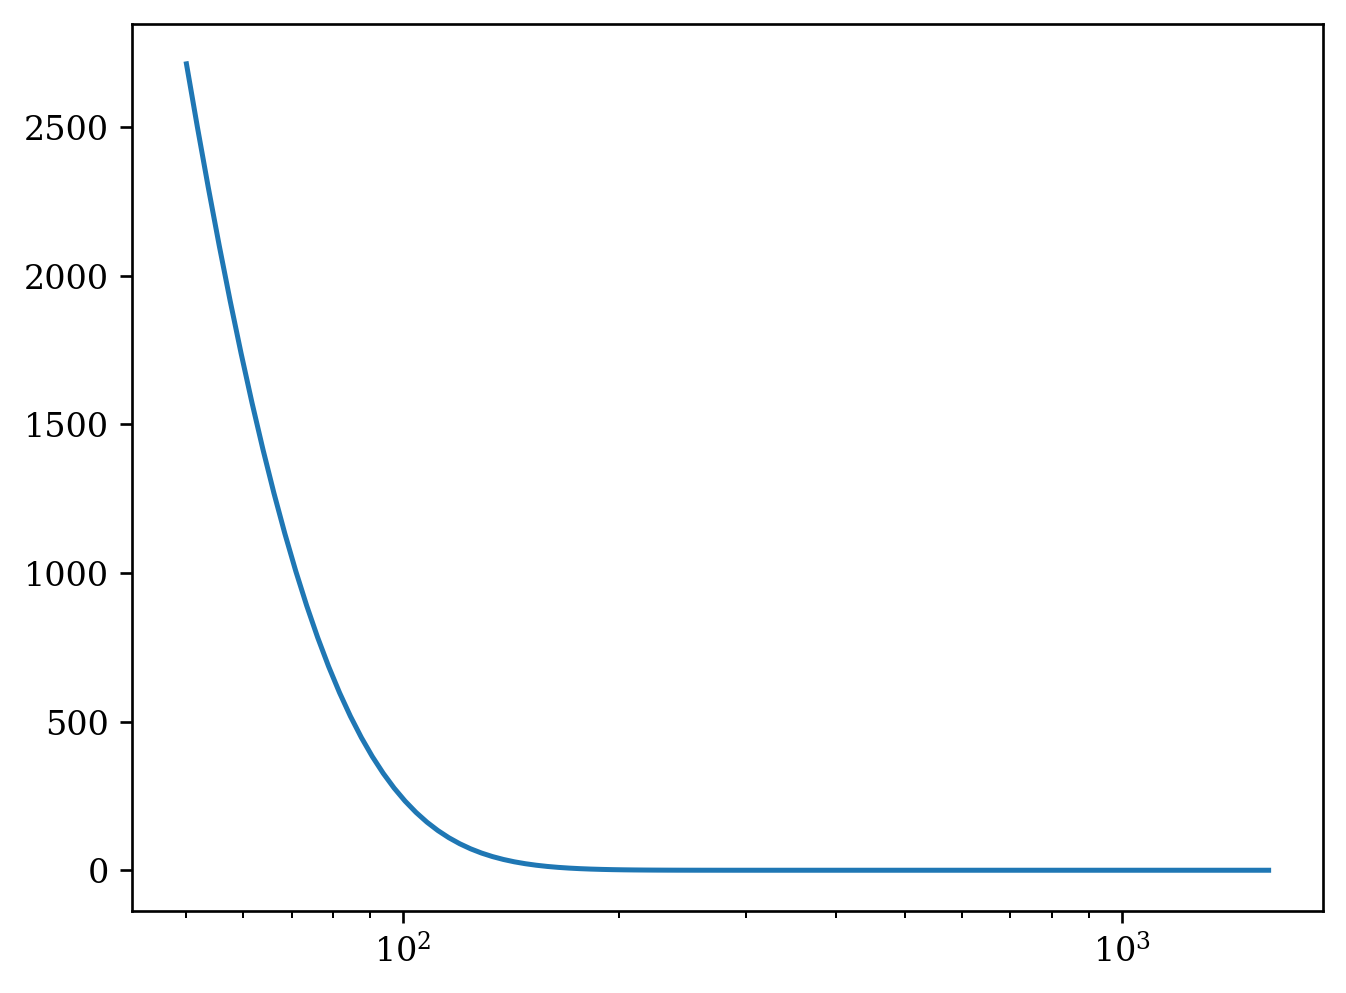

In [124]:
dtph_dense = np.geomspace(50, 1600, 100)
plt.plot(dtph_dense, intensidad_func(dtph_dense, 20, 0.9))
plt.xscale("log")
plt.show()

cuentas auxiliares

In [24]:
times_str = """\
50 -> 10 11 20, 10 16 40
100 -> 10 18 59, 10 24 19
200 -> 10 26 37, 10 31 58
400 -> 10 34 17, 10 39 38"""
parsed_times_str = [line.split(" -> ") for line in times_str.splitlines()]
dtphs = [parsed_strs[0] for parsed_strs in parsed_times_str]
times = [parsed_strs[1].split(", ") for parsed_strs in parsed_times_str]

In [31]:
starts_parsed = [time[0].split(" ") for time in times]
start_secs = [int(start[0])*3600 + int(start[1])*60 + int(start[2]) for start in starts_parsed]
ends_parsed = [time[1].split(" ") for time in times]
end_secs = [int(end[0])*3600 + int(end[1])*60 + int(end[2]) for end in ends_parsed]

durations = [end - start for start, end in zip(start_secs, end_secs)]
durations

[320, 320, 321, 321]

# Imágenes Santi

## Detección de dipolos

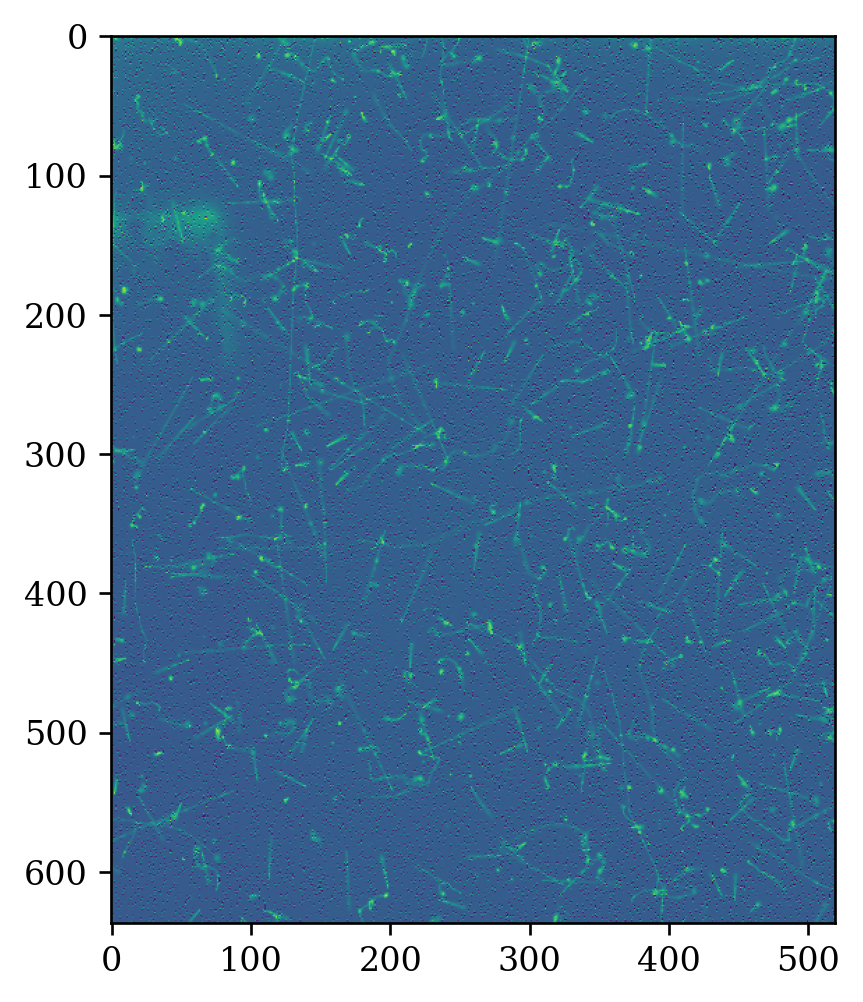

16934


In [ ]:
plt.close("all")
%matplotlib inline
data_dir = 'skipper_data\Imagenes_Santi'
t_ilum = 0.25
threshold = 0.7e11
#test_image = fits.open(f'{data_dir}\proc_skp_mod45_2ndbatch_T150_Vv2_seqrevOS_vdd-17_loopdtph_wledon140_npump40000_dtph100_NSAMP10_NROW650_NCOL650_EXPOSURE0_NBINROW1_NBINCOL1_img40.fits')
test_image = fits.open(f'{data_dir}\proc_skp_mod45_2ndbatch_T150_Vv2_seqrevOS_vdd-17_loopdtph_wledon140_npump40000_dtph2000000_NSAMP10_NROW650_NCOL650_EXPOSURE0_NBINROW1_NBINCOL1_img58.fits')
#test_image = correct_overscan(test_image)
test_frame = test_image[0].data
r_overscan, c_overscan = get_rowcol_ovserscan(test_image)
test_frame = test_frame[1:-r_overscan-1, PRESCAN_PIX+1:-c_overscan]
test_frame = test_frame-np.median(test_frame, axis=0)
dif_1 = np.diff(test_frame, axis=0, )
dif_2 = np.diff(test_frame[::-1], axis=0, )[::-1]
mascara_dipolos = np.zeros_like(dif_1, dtype=int)

prod_arr = test_frame[:-1] * test_frame[1:]
#prod_arr = dif_1 * dif_2
mascara_dipolos[prod_arr>=-threshold] = 0
mascara_dipolos[prod_arr<-threshold] = 1
coordenadas_trampas = []
for j, col in enumerate(prod_arr.T):
    for i, val in enumerate(col):
        if mascara_dipolos[i, j] == 1:
            if i == 0:
                i_lleno = np.argmax(test_frame[i:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i:i+2, j])
                i_vacio = i_vacio + i - 1
            elif i == len(col):
                i_lleno = np.argmax(test_frame[i-1:i+1, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+1, j])
                i_vacio = i_vacio + i - 1
            else:
                i_lleno = np.argmax(test_frame[i-1:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+2, j])
                i_vacio = i_vacio + i - 1
            if np.abs(i_lleno-i_vacio)==1:
               coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
#
# filtro_dipolos
#plt.imshow(np.log(np.abs(dif_1)+1))
plt.imshow(test_frame)
#plt.colorbar()

plt.show()

#plt.imshow(prod_arr)
#plt.colorbar()
#plt.show()
#plt.imshow(np.log(np.abs(mascara_dipolos)+1))
#plt.colorbar()
#plt.show()
#plt.imshow(np.log(np.abs(test_frame)+1))
#plt.imshow(test_frame)
#plt.colorbar()
#plt.show()
print(len(coordenadas_trampas))

Histograma para elegir el threshold

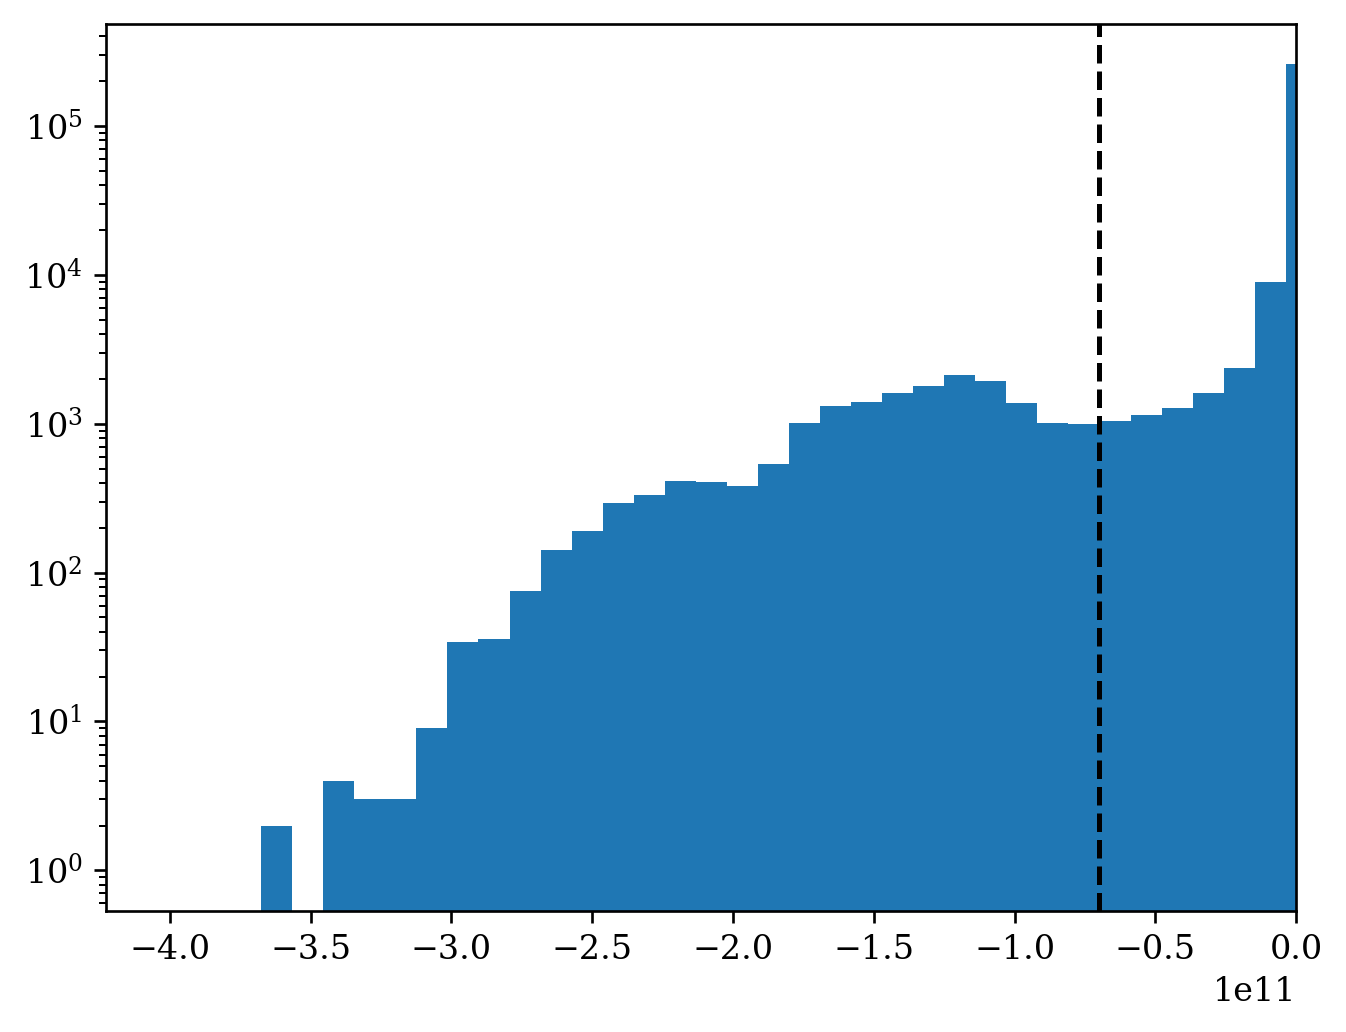

In [ ]:
plt.hist(prod_arr.flatten(), bins = 100)
plt.xlim(xmax = 0)
plt.yscale('log')
plt.axvline(x = -threshold, color='k', ls = '--')
#plt.ylim(ymax = 100)
plt.show()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_12700\1358130242.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(colors)


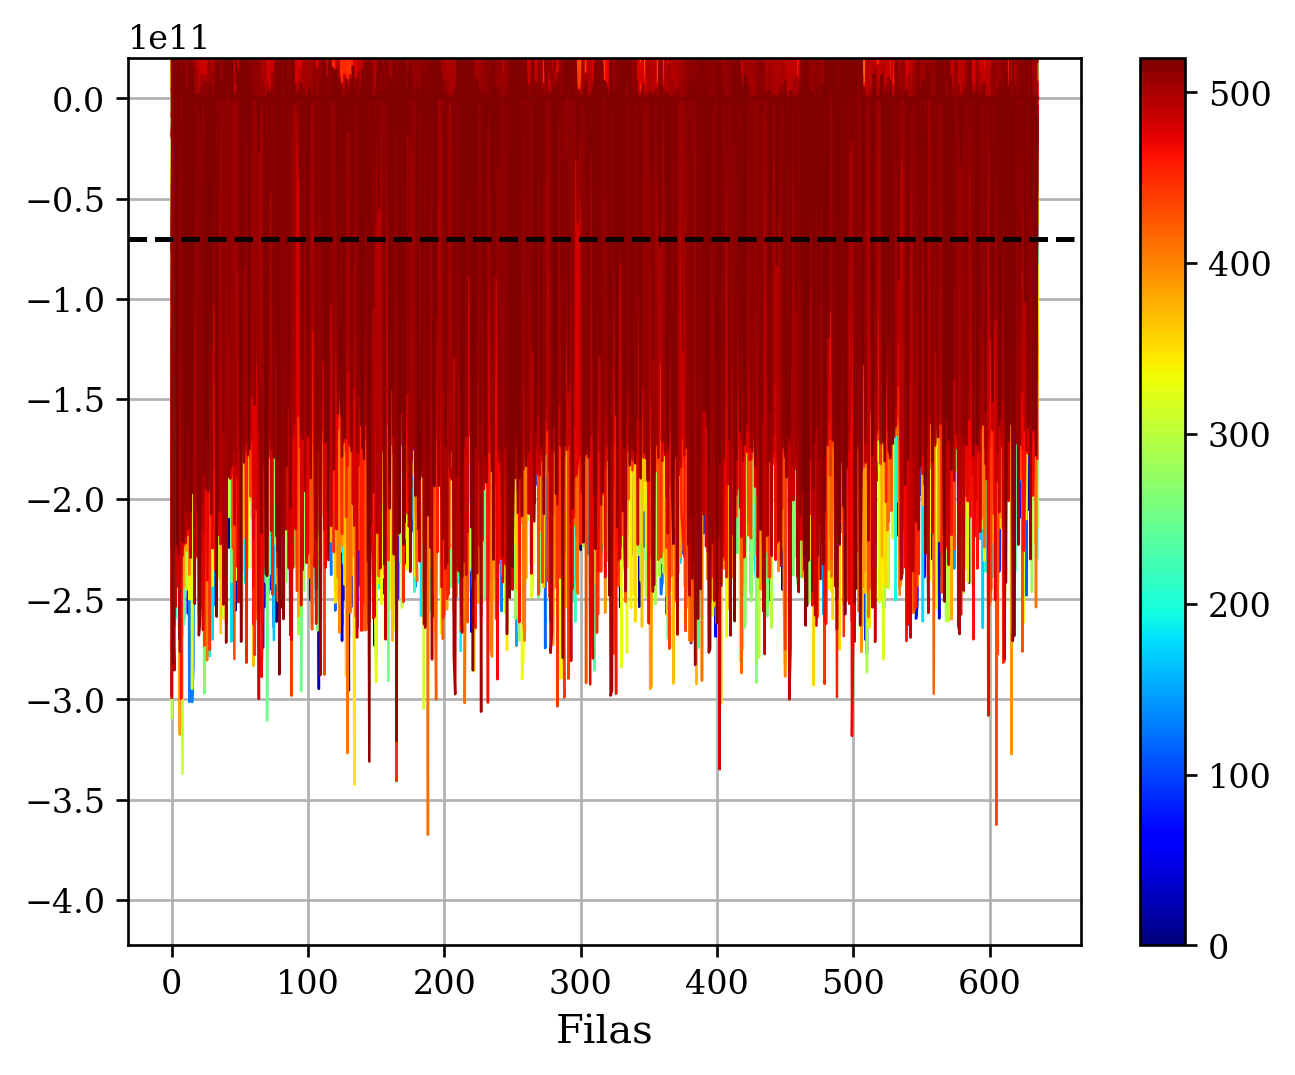

In [ ]:
plt.close('all')
%matplotlib inline
colors = plt.cm.ScalarMappable(norm=plt.Normalize(0, prod_arr.shape[1]),
                               cmap="jet")
for j, col in enumerate(prod_arr.T):
    #if j <100 : 
    #    plt.plot(col, color = 'k')
    #if j >= 100 and j < 200 : 
    #    plt.plot(col, color = 'b')
    #if j >=200 and j< 300: 
    #    plt.plot(col, color = 'g')
    #if j >= 300 and j < 400 : 
    #    plt.plot(col, color = 'm')
    #if j >= 400 and j < 500 : 
    #    plt.plot(col, color = 'r')
    #if j > 500:
    #    plt.plot(col, color = 'c') 
    plt.plot(col, lw=0.75, color=colors.to_rgba(j))
    
    #for i, val in enumerate(col):
    #    if val < -threshold:
    #        print(i, j)
#for col in dif_1.T:
#    plt.plot(col)
plt.xlabel("Filas")
#plt.axhline(threshold, xmin = 0, xmax = 828, ls = '--', color='k')
plt.axhline(-threshold, xmin = 0, xmax = 828, ls ='--', color = 'k')
plt.ylim(top= 0.2e11 )
plt.colorbar(colors)
plt.grid()
plt.show()
#for j, col in enumerate(test_frame.T):
#    if j <100 : 
#        plt.plot(col, color = 'k')
#    if j >= 100 and j < 200 : 
#        plt.plot(col, color = 'b')
#    if j >=200 and j< 300: 
#        plt.plot(col, color = 'g')
#    if j >= 300 and j < 400 : 
#        plt.plot(col, color = 'm')
#    if j >= 400 and j < 500 : 
#        plt.plot(col, color = 'r')
#    if j > 500:
#        plt.plot(col, color = 'c') 

#plt.xlabel("Filas")
#plt.show()

Filtro por simetría

In [ ]:
plt.close('all')
trampas_filtradas = []
corte_simetria = 80
for trampa in tqdm(coordenadas_trampas):
    fila_vals = [coord[0] for coord in trampa]
    col_vals = [coord[1] for coord in trampa]
    #print(fila_vals)
    val_1  = test_frame[fila_vals[0], col_vals[0]]
    val_2 = test_frame[fila_vals[1], col_vals[1]]
    diferencia_relativa = np.abs(100*(np.abs(val_1)-np.abs(val_2))/np.max([np.abs(val_1), np.abs(val_2)]))
    #print(diferencia_relativa)
    if diferencia_relativa < corte_simetria:
        trampas_filtradas.append(trampa)
print(len(coordenadas_trampas))
print(len(trampas_filtradas))

  0%|          | 0/16934 [00:00<?, ?it/s]

16934
16881


  0%|          | 0/16934 [00:00<?, ?it/s]

  0%|          | 0/16881 [00:00<?, ?it/s]

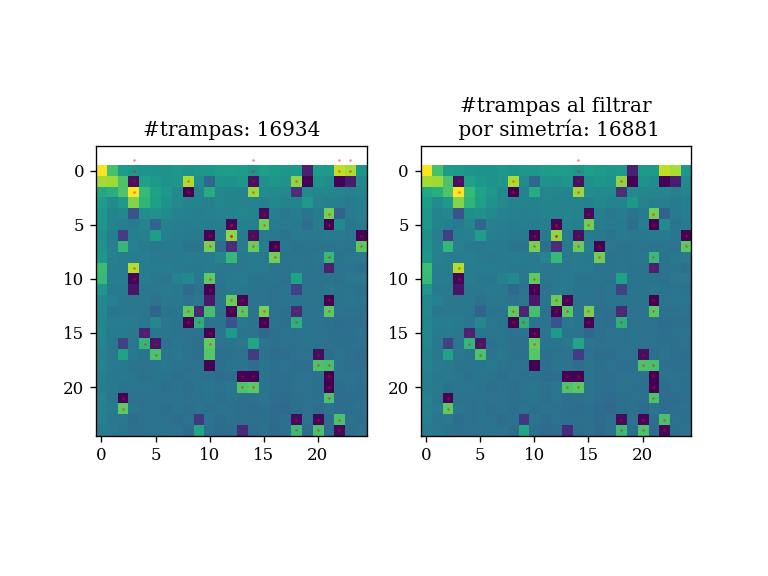

In [ ]:
from tqdm.notebook import tqdm
plt.close('all')
%matplotlib widget
fig, axs = plt.subplots(1, 2)
#fig, ax = plt.subplots(1, 1)
axs[0].imshow(test_frame[:25, :25])
#axs[0].imshow(test_frame)
axs[0].set_title(f'#trampas: {len(coordenadas_trampas)}')
for trampa in tqdm(coordenadas_trampas):
    fila_vals = [coord[0] for coord in trampa]
    col_vals = [coord[1] for coord in trampa]
    if max(col_vals)<25 and max(fila_vals)<25:
        axs[0].plot(col_vals, fila_vals, '.r', ms=1, alpha=0.5) 
axs[1].imshow(test_frame[:25, :25])
#axs[1].imshow(test_frame)
axs[1].set_title(f'#trampas al filtrar\n por simetría: {len(trampas_filtradas)}')
for trampa in tqdm(trampas_filtradas):
    fila_vals = [coord[0] for coord in trampa]
    col_vals = [coord[1] for coord in trampa]
    if max(col_vals)<25 and max(fila_vals)<25:
        axs[1].plot(col_vals, fila_vals, '.r', ms=1, alpha=0.5) 
#axs[1].imshow(mascara_dipolos)
plt.show()
if False:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 400:500])
    axs[1].imshow(mascara_dipolos[0:100, 400:500])
    plt.show()

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 200:300])
    axs[1].imshow(mascara_dipolos[0:100, 200:300])
    plt.show()
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(test_frame[0:100, 200:300])
    axs[1].imshow(mascara_dipolos[0:100, 200:300])
    plt.show()

Eficiencia del algoritmo

In [ ]:
N_trampas = 50
print(f'Agrego {N_trampas} trampas ficticias')
coord_fake_traps = []
fake_traps = np.zeros_like(test_frame)
for i in range(N_trampas):
    x = int(np.random.rand(1,1)[0,0]*len(test_frame[:,0]))
    y = int(np.random.rand(1,1)[0,0]*len(test_frame[0,:]))
    #coord_fake_traps.append([x,y])
    fake_traps[x,y] = np.sqrt(2*threshold)
    fake_traps[x-1,y] = -np.sqrt(2*threshold)
    #print([x,y])
#plt.imshow(fake_traps)
mod_frame = test_frame + fake_traps

#busco las coordenadas de las trampas en la imagen original
dif_1 = np.diff(test_frame, axis=0, )
dif_2 = np.diff(test_frame[::-1], axis=0, )[::-1]
mascara_dipolos = np.zeros_like(dif_1, dtype=int)

prod_arr = test_frame[:-1] * test_frame[1:]
#prod_arr = dif_1 * dif_2
mascara_dipolos[prod_arr>=-threshold] = 0
mascara_dipolos[prod_arr<-threshold] = 1
coordenadas_trampas = []
for j, col in enumerate(prod_arr.T):
    for i, val in enumerate(col):
        if mascara_dipolos[i, j] == 1:
            if i == 0:
                i_lleno = np.argmax(test_frame[i:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i:i+2, j])
                i_vacio = i_vacio + i - 1
            elif i == len(col):
                i_lleno = np.argmax(test_frame[i-1:i+1, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+1, j])
                i_vacio = i_vacio + i - 1
            else:
                i_lleno = np.argmax(test_frame[i-1:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(test_frame[i-1:i+2, j])
                i_vacio = i_vacio + i - 1
            if np.abs(i_lleno-i_vacio)==1:
               coordenadas_trampas.append(((i_lleno, j), (i_vacio, j)))
print(f'La cantidad de trampas es {len(coordenadas_trampas)}')

#busco las coordenadas de las trampas en la imagen modificada
dif_1_fake = np.diff(mod_frame, axis=0, )
dif_2_fake = np.diff(mod_frame[::-1], axis=0, )[::-1]
mascara_dipolos_fake = np.zeros_like(dif_1_fake, dtype=int)

prod_arr_fake = mod_frame[:-1] * mod_frame[1:]
#prod_arr = dif_1 * dif_2
mascara_dipolos_fake[prod_arr_fake>=-threshold] = 0
mascara_dipolos_fake[prod_arr_fake<-threshold] = 1
coordenadas_trampas_fake = []
for j, col in enumerate(prod_arr_fake.T):
    for i, val in enumerate(col):
        if mascara_dipolos_fake[i, j] == 1:
            if i == 0:
                i_lleno = np.argmax(mod_frame[i:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(mod_frame[i:i+2, j])
                i_vacio = i_vacio + i - 1
            elif i == len(col):
                i_lleno = np.argmax(mod_frame[i-1:i+1, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(mod_frame[i-1:i+1, j])
                i_vacio = i_vacio + i - 1
            else:
                i_lleno = np.argmax(mod_frame[i-1:i+2, j])
                i_lleno = i_lleno + i - 1
                i_vacio = np.argmin(mod_frame[i-1:i+2, j])
                i_vacio = i_vacio + i - 1
            if np.abs(i_lleno-i_vacio)==1:
                coordenadas_trampas_fake.append(((i_lleno, j), (i_vacio, j)))

print(f'La cantidad de trampas es la imagen modificada es {len(coordenadas_trampas_fake)}')

print(f'La eficiencia es de {(len(coordenadas_trampas_fake)-len(coordenadas_trampas))/N_trampas *100}%')
#from tqdm.notebook import tqdm
#plt.close('all')
#%matplotlib widget
#fig, axs = plt.subplots(1, 2)
#fig, ax = plt.subplots(1, 1)
#ax.imshow(mod_frame)
#for trampa in tqdm(coordenadas_trampas_fake):
#    fila_vals = [coord[0] for coord in trampa]
#    col_vals = [coord[1] for coord in trampa]
#    ax.plot(col_vals, fila_vals, '.r', ms=1, alpha=0.5) 
#axs[1].imshow(mascara_dipolos)
#plt.show()



Agrego 50 trampas ficticias
La cantidad de trampas es 14
La cantidad de trampas es la imagen modificada es 61
La eficiencia es de 94.0%
